Function to display images. np_array -> matplotlib.plot

In [1]:
import cv2
import matplotlib.pyplot as plt

def display_cv2(image):
    dpi = 80
    # Convert BGR to RGB if image has 3 channels
    if len(image.shape) == 3 and image.shape[2] == 3:
        im_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        im_data = image 
    height, width = im_data.shape[:2]
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(im_data, cmap='gray' if len(im_data.shape) == 2 else None)
    plt.show()

### 1. Read image, rescale
when the image is too small, characters merge and strokes are lost, causing OCR errors. we upsample by scale so both dimensions meet threshold: 300w and 200h

Image rescaled from (342, 100) to (684, 200)


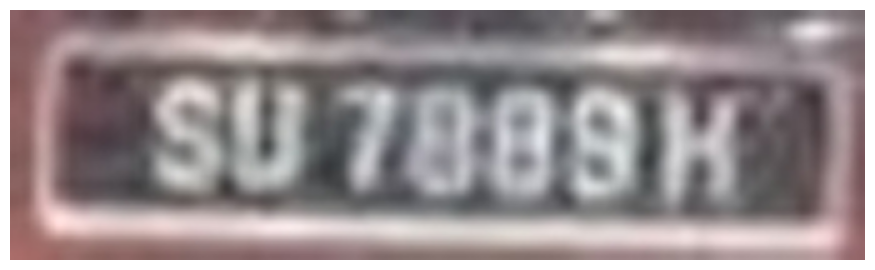

In [2]:
image_file = "./temp/sample.jpg"
min_width = 300
min_height = 200

img = cv2.imread(image_file)
height, width = img.shape[:2]

# Check if rescaling is needed
if width < min_width or height < min_height:
    # Calculate new size while maintaining aspect ratio
    scale_w = min_width / width
    scale_h = min_height / height
    scale = max(scale_w, scale_h)  # scale so both dimensions meet threshold
    new_width = int(width * scale)
    new_height = int(height * scale)

    img_resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    print(f"Image rescaled from ({width}, {height}) to ({new_width}, {new_height})")
else:
    img_resized = img
    print(f"Image size ({width}, {height}) is above threshold, no rescaling.")

display_cv2(img_resized)

### 2. Invert image
found out that most OCR engines are designed to read dark text on a light background.
They detect the text as the foreground (non-zero pixels) and background as zero. Since Malaysian plates are commonly white texts on black backgrounds, we apply this preprocessing step.



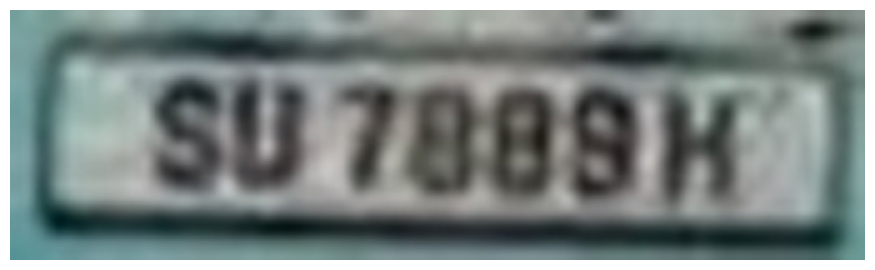

In [3]:
img_resized = cv2.bitwise_not(img_resized)
display_cv2(img_resized)

### 3. Grayscale
Grayscale Keeps character shapes intact while discarding irrelevant color, reduces computation and memory since only one channel is needed to process.

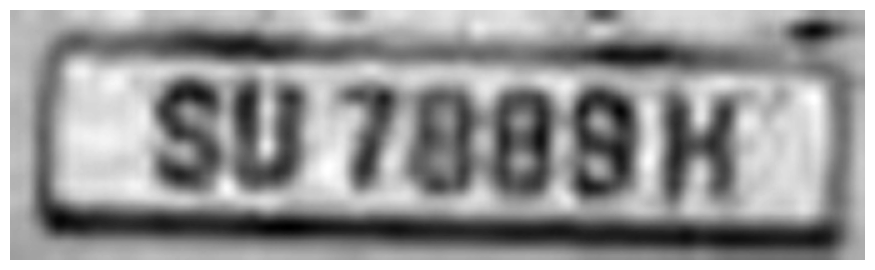

In [4]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

img_resized = grayscale(img_resized)
display_cv2(img_resized)

### 4. Noise Removal
Morphological closing fills small gaps in letters to make them continuous, and sharpening enhances edges so characters are crisp and distinct, both making the text easier for OCR to recognize.

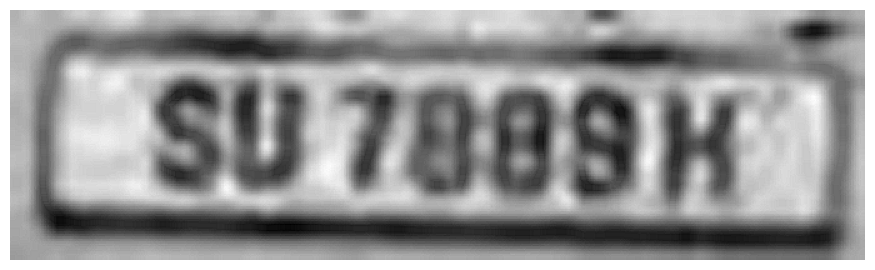

In [5]:
import numpy as np

def noise_removal_sharp(image):

    # 1. Morphological closing, close small gaps in characters (dilates then erodes).
    kernel = np.ones((3, 3), np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 2. Apply sharpen 
    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5,-1],
                             [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel_sharp)
    return image

img_resized = noise_removal_sharp(img_resized)
display_cv2(img_resized)

### 5. CLAHE
CLAHE divides the image into small tiles and applies adaptive histogram equalization with contrast limits to enhance local details.
This makes characters clearer and edges sharper, improving OCR recognition

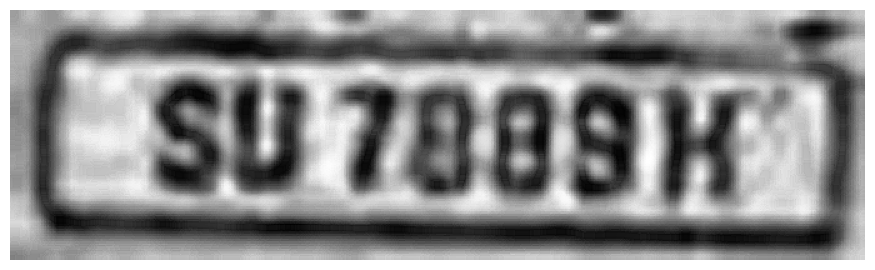

In [6]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_resized = clahe.apply(img_resized)
 
display_cv2(img_resized)

### 6. Corrode
After CLAHE, text strokes can become thicker due to local contrast enhancement. Applying erosion (corrode) aims to slims the characters back to a normal width, improving OCR readability.

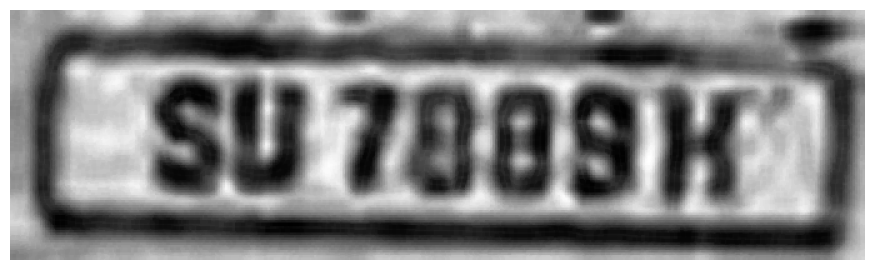

In [ ]:
kernel = np.ones((3,3), np.uint8)
thinner = cv2.erode(img_resized, kernel, iterations=1)

#cv2.imwrite('processed1.jpg', thinner)
display_cv2(thinner)

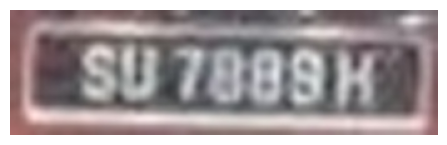

In [ ]:
# the original image

display_cv2(img)